# Import libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from skimage.color import rgb2lab
from skimage import img_as_float
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
import xgboost as xgb

# read the dataset

In [44]:
dataset_path =os .path.join(os.getcwd(), '..', 'Dataset','classes')

# Define the splits you want to process
splits = ['train', 'test']

for split in splits:
    split_path = os.path.join(dataset_path, split)
    if not os.path.exists(split_path):
        print(f"Directory not found: {split_path}")
        continue

    print(f"\n--- {split.upper()} FOLDER ---")
    # List subdirectories inside each split (expected: benign and malignant)
    for category in os.listdir(split_path):
        category_path = os.path.join(split_path, category)
        if os.path.isdir(category_path):
            # List all files (assuming images) in the category folder
            files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
            print(f"Category: {category} -- {len(files)} files")
        else:
            print(f"Skipping non-directory item: {category}")



--- TRAIN FOLDER ---
Category: benign -- 1440 files
Category: malignant -- 1197 files

--- TEST FOLDER ---
Category: benign -- 360 files
Category: malignant -- 300 files


# visualizations

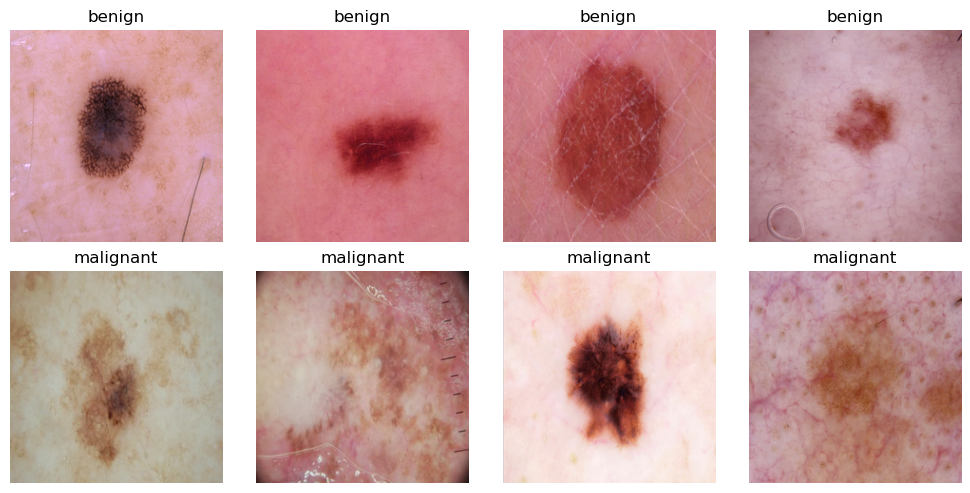

In [45]:
# Path to the training folder
train_path = os.path.join(dataset_path, 'train')
categories = ['benign', 'malignant']

# Number of images to display per category
num_images = 4

plt.figure(figsize=(10, 5))
for i, category in enumerate(categories):
    category_dir = os.path.join(train_path, category)
    # Get a few image names from the category folder
    img_names = os.listdir(category_dir)[:num_images]
    
    for j, img_name in enumerate(img_names):
        img_path = os.path.join(category_dir, img_name)
        # Load the image (resizing to 224x224; adjust if needed)
        img = load_img(img_path, target_size=(224,224))
        plt.subplot(len(categories), num_images, i*num_images + j + 1)
        plt.imshow(img)
        plt.title(f"{category}")
        plt.axis('off')

plt.tight_layout()
plt.show()


# Define generators

In [12]:
# For this example, we assume images are read in RGB format.
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)
target_size = (224, 224)  

# Create generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'train'),
    target_size=target_size,
    batch_size=32,
    class_mode='binary',  
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'test'),
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


# Feature extraction

In [13]:
def extract_color_features(images):
    features = []
    for img in images:
        # Ensure image is float and normalized to [0,1]
        img = img_as_float(img)
        
        if np.isnan(img).any() or np.isinf(img).any():
            raise ValueError("Image contains NaN or infinite values.")

        # Convert image from RGB to LAB color space
        lab = rgb2lab(img)

        # Extract L, A, B channels
        L, A, B = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

        # Compute statistical moments for each channel
        l_mean, l_std = np.mean(L), np.std(L)
        l_skew, l_kurt = skew(L.flatten()), kurtosis(L.flatten())
        a_mean, a_std = np.mean(A), np.std(A)
        a_skew, a_kurt = skew(A.flatten()), kurtosis(A.flatten())
        b_mean, b_std = np.mean(B), np.std(B)
        b_skew, b_kurt = skew(B.flatten()), kurtosis(B.flatten())

        # Compute histograms for each channel (normalized)
        # For L channel, LAB L ranges approximately 0-100; for A and B, about -128 to 128.
        l_hist, _ = np.histogram(L.flatten(), bins=256, range=(0, 100), density=True)
        a_hist, _ = np.histogram(A.flatten(), bins=256, range=(-128, 128), density=True)
        b_hist, _ = np.histogram(B.flatten(), bins=256, range=(-128, 128), density=True)

        # Flatten and concatenate histograms
        hist_features = np.concatenate([l_hist, a_hist, b_hist])

        # Combine statistical moments into one feature vector
        moment_features = np.array([
            l_mean, l_std, l_skew, l_kurt,
            a_mean, a_std, a_skew, a_kurt,
            b_mean, b_std, b_skew, b_kurt
        ])

        # Final feature vector: statistical features + histogram features
        feature_vector = np.concatenate([moment_features, hist_features])
        features.append(feature_vector)

    return np.array(features)



In [14]:
# Helper function to iterate through a generator and extract features
def extract_features_from_generator(generator, num_samples):
    all_features = []
    all_labels = []
    steps = int(np.ceil(num_samples / generator.batch_size))
    for _ in range(steps):
        imgs, labels = next(generator)
        batch_features = extract_color_features(imgs)
        all_features.append(batch_features)
        all_labels.append(labels)
    return np.vstack(all_features), np.concatenate(all_labels)

# Number of samples can be obtained from the generator's n attribute
num_train = train_generator.n
num_test  = test_generator.n

print("Extracting features for training set...")
X_train, y_train = extract_features_from_generator(train_generator, num_train)
print("Training features shape:", X_train.shape)

print("Extracting features for testing set...")
X_test, y_test = extract_features_from_generator(test_generator, num_test)
print("Testing features shape:", X_test.shape)


Extracting features for training set...
Training features shape: (2637, 780)
Extracting features for testing set...
Testing features shape: (660, 780)


# model development and evaluation

### XGBClassifier (highest acc)

In [29]:
clf = xgb.XGBClassifier(random_state=42, max_depth=10, n_estimators=100)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
# Predict on test data
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%")

Test Accuracy: 88.18%


Text(0.5, 25.722222222222214, 'Predicted labels')

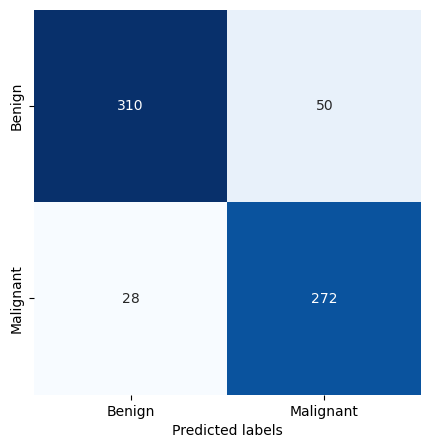

In [31]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted labels')

In [32]:
# classification report
print(classification_report(y_test, y_pred, target_names=categories))


              precision    recall  f1-score   support

      benign       0.92      0.86      0.89       360
   malignant       0.84      0.91      0.87       300

    accuracy                           0.88       660
   macro avg       0.88      0.88      0.88       660
weighted avg       0.88      0.88      0.88       660



### LogisticRegression

In [55]:
lr_clf = LogisticRegression(random_state=42, max_iter=2000)
lr_clf.fit(X_train, y_train)
lr_predictions = lr_clf.predict(X_test)
lr_acc = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Test Accuracy: {lr_acc*100:.2f}%")

Logistic Regression Test Accuracy: 81.82%


In [46]:
print(classification_report(y_test, lr_predictions, target_names=categories))


              precision    recall  f1-score   support

      benign       0.86      0.80      0.83       360
   malignant       0.78      0.84      0.81       300

    accuracy                           0.82       660
   macro avg       0.82      0.82      0.82       660
weighted avg       0.82      0.82      0.82       660



Text(0.5, 25.722222222222214, 'Predicted labels')

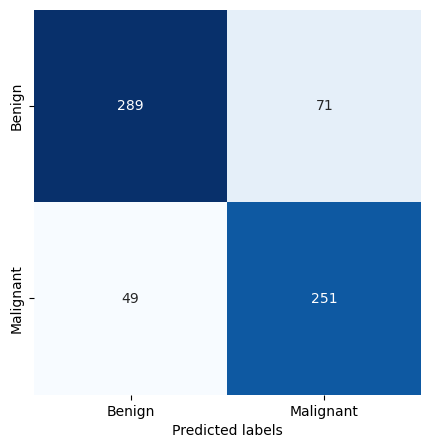

In [47]:
# Plot confusion matrix
cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted labels')

### RandomForestClassifier

In [52]:
rf_clf = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=200)
rf_clf.fit(X_train, y_train)
rf_predictions = rf_clf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Test Accuracy: {rf_acc*100:.2f}%")


Random Forest Test Accuracy: 85.61%


In [53]:
print(classification_report(y_test, rf_predictions, target_names=categories))


              precision    recall  f1-score   support

      benign       0.92      0.81      0.86       360
   malignant       0.80      0.91      0.85       300

    accuracy                           0.86       660
   macro avg       0.86      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660



Text(0.5, 25.722222222222214, 'Predicted labels')

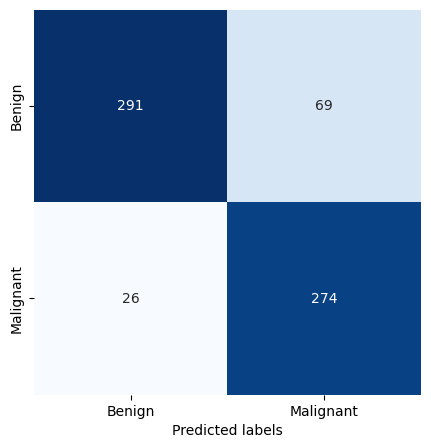

In [54]:
cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted labels')